# 4 - Model building

## I have toyed a couple configurations of the model and decided to go with this stacked neural network
- Last 7 days features go into a RNN
- Last 7 days features go into a CNN
- Last 2 hours features go into a RNN
- Distance/datetime features go in a DNN
- Last 7th day features go into a DNN
- Outputs of all serve as metadata and feed into a DNN to predict 5 outputs

## Hyperparameter
- I tried to make this a great balance of complexity and accuracy
- The learning rate is difficult as model easily converges into a 'bad' local minima
- While I can't guarantee that I have got the global minima, but the results look pretty good to me

In [3]:
import numpy as np
import pandas as pd

from keras.models import *
from keras.layers import *
from keras.activations import *
from keras.optimizers import *
from keras.losses import *
from keras import backend as K

import tensorflow as tf
print(tf.__version__)

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

Using TensorFlow backend.


1.14.1-dev20190607


In [4]:
def root_mean_squared_error(y_true, y_pred):
    '''RMSE in keras'''
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def symmetric_mean_absolute_mean_error(y_true, y_pred):
    '''SMAPE - modified (got it from kaggle)'''
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

def calculate_rmse(x, y):
    '''RMSE in numpy'''
    return np.sum(np.absolute(x - y))/x.shape[0]

def calculate_smape(y_true, y_pred):
    '''This is just a function wrapper lol'''
    return symmetric_mean_absolute_mean_error(y_true, y_pred)

In [5]:
train_df = pd.read_pickle('../data/preprocessed_train_df_for_training.pkl')
eval_df = pd.read_pickle('../data/preprocessed_eval_df_for_training.pkl')

In [6]:
raw_feat = [
    'distance_from_qp09d8', 'distance_from_qp03xx', 'distance_from_qp03wf',
    'day_of_week_sin', 'day_of_week_cos',
    'hour_sin', 'hour_cos',
    'fifteen_minute_sin', 'fifteen_minute_cos',
]

last_two_hour_feat = ['demand_t{0}'.format(t) for t in range(8)]

last_six_day_feat = []
for d in range(6, 0, -1):
    for i in range(13):
        last_six_day_feat.append('demand_{0}d_t{1}'.format(d, i))

last_week_today_feat = ['demand_7d_t{0}'.format(i) for i in range(13)]

target = ['target_1', 'target_2', 'target_3', 'target_4', 'target_5']

In [7]:
X_train_raw = train_df[raw_feat]
X_eval_raw = eval_df[raw_feat]

X_train_last_two_hour = train_df[last_two_hour_feat]
X_eval_last_two_hour = eval_df[last_two_hour_feat]

X_train_last_week = train_df[last_week_today_feat]
X_eval_last_week = eval_df[last_week_today_feat]

X_train_last_six_day = train_df[last_six_day_feat]
X_eval_last_six_day = eval_df[last_six_day_feat]


Y_train = train_df[target]
Y_eval = eval_df[target]

In [8]:
tf.set_random_seed(2019) # make sure keras will get reproducible result 

In [9]:
raw_inputs = Input(shape=(len(raw_feat),))
last_two_hour_inputs = Input(shape=(len(last_two_hour_feat),))
last_week_today_inputs = Input(shape=(len(last_week_today_feat),))
last_six_day_inputs = Input(shape=(len(last_six_day_feat),))

daily_cnn = concatenate([last_week_today_inputs, last_six_day_inputs])
daily_cnn = Reshape((7, len(last_week_today_feat),))(daily_cnn)
daily_cnn = Conv1D(16, 5, activation=relu, padding='same')(daily_cnn)
daily_cnn = MaxPool1D(2, 2, padding='same')(daily_cnn)
daily_cnn = Conv1D(8, 3, activation=relu, padding='same')(daily_cnn)
daily_cnn = MaxPool1D(2, 2, padding='same')(daily_cnn)
daily_cnn = Flatten()(daily_cnn)
daily_cnn = Model(inputs=[last_week_today_inputs, last_six_day_inputs], outputs=daily_cnn)

daily_rnn = concatenate([last_week_today_inputs, last_six_day_inputs])
daily_rnn = Reshape((7, len(last_week_today_feat),))(daily_rnn)
daily_rnn = GRU(32, return_sequences=True)(daily_rnn)
daily_rnn = GRU(16)(daily_rnn)
daily_rnn = Model(inputs=[last_week_today_inputs, last_six_day_inputs], outputs=daily_rnn)

raw_dnn = Dense(64, activation=relu)(raw_inputs)
raw_dnn = Dense(32, activation=relu)(raw_dnn)
raw_dnn = Dense(16, activation=relu)(raw_dnn)
raw_dnn = Model(inputs=raw_inputs, outputs=raw_dnn)

attention_dnn = Dense(64, activation=relu)(last_week_today_inputs)
attention_dnn = Dense(32, activation=relu)(attention_dnn)
attention_dnn = Dense(16, activation=relu)(attention_dnn)
attention_dnn = Model(inputs=last_week_today_inputs, outputs=attention_dnn)

last_two_hour_rnn = Reshape((len(last_two_hour_feat), 1, ))(last_two_hour_inputs)
last_two_hour_rnn = GRU(32, return_sequences=True)(last_two_hour_rnn)
last_two_hour_rnn = GRU(16)(last_two_hour_rnn)
last_two_hour_rnn = Model(inputs=last_two_hour_inputs, outputs=last_two_hour_rnn)

# last_week_today_inputs act as attention
final_stacked = concatenate([raw_dnn.output, 
                             daily_rnn.output, 
                             daily_cnn.output, 
                             attention_dnn.output, 
                             last_two_hour_rnn.output])
final_stacked = Dense(64, activation=relu)(final_stacked)
final_stacked = Dense(32, activation=relu)(final_stacked)
final_stacked = Dense(16, activation=relu)(final_stacked)
final_stacked = Dense(5, activation=hard_sigmoid)(final_stacked)
final_stacked = Model(inputs=[raw_inputs, last_week_today_inputs, last_six_day_inputs, last_two_hour_inputs],
                      outputs=final_stacked)

final_stacked.summary()

W0617 20:54:52.411050 4672525760 deprecation_wrapper.py:118] From /anaconda3/envs/grab/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 20:54:52.429888 4672525760 deprecation_wrapper.py:118] From /anaconda3/envs/grab/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 20:54:52.589108 4672525760 deprecation_wrapper.py:118] From /anaconda3/envs/grab/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0617 20:54:52.678647 4672525760 deprecation_wrapper.py:118] From /anaconda3/envs/grab/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 13)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 78)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 91)           0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 7, 13)        0           concatenate_1[0][0]              
__________

In [10]:
# While Adagrad has great lr update, but this gives the model a little kick
for lr, ep in [(0.01, 1), (0.005, 1), (0.003, 1),
               (0.005, 1), (0.0003, 1), (0.0001, 1)]:
    final_stacked.compile(optimizer=Adagrad(lr=lr), loss=mean_squared_error, metrics=[root_mean_squared_error],)
    final_stacked.fit(
        [X_train_raw, X_train_last_week, X_train_last_six_day, X_train_last_two_hour], Y_train,
        batch_size=256, epochs=ep,
        validation_data=([X_eval_raw, X_eval_last_week, X_eval_last_six_day, X_eval_last_two_hour], Y_eval),
    )

W0617 20:54:54.381494 4672525760 deprecation_wrapper.py:118] From /anaconda3/envs/grab/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0617 20:54:54.678704 4672525760 deprecation.py:323] From /anaconda3/envs/grab/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0617 20:54:57.991411 4672525760 deprecation_wrapper.py:118] From /anaconda3/envs/grab/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0617 20:54:57.995366 4672525760 deprecation_wrapper.py:118] From /anaconda3/envs/grab/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973

Train on 5482125 samples, validate on 1395450 samples
Epoch 1/1
5482125/5482125 [==============================] - 552s 101us/step - loss: 8.4808e-04 - root_mean_squared_error: 0.0281 - val_loss: 9.0709e-04 - val_root_mean_squared_error: 0.0224
Train on 5482125 samples, validate on 1395450 samples
Epoch 1/1
5482125/5482125 [==============================] - 460s 84us/step - loss: 7.5342e-04 - root_mean_squared_error: 0.0270 - val_loss: 8.7338e-04 - val_root_mean_squared_error: 0.0220
Train on 5482125 samples, validate on 1395450 samples
Epoch 1/1
5482125/5482125 [==============================] - 485s 89us/step - loss: 7.3902e-04 - root_mean_squared_error: 0.0268 - val_loss: 8.6975e-04 - val_root_mean_squared_error: 0.0219
Train on 5482125 samples, validate on 1395450 samples
Epoch 1/1
5482125/5482125 [==============================] - 489s 89us/step - loss: 7.3648e-04 - root_mean_squared_error: 0.0267 - val_loss: 8.6371e-04 - val_root_mean_squared_error: 0.0219
Train on 5482125 sample

In [11]:
final_stacked.save('../model/final_stacked_80.h5')

In [12]:
stacked_rmse = []
for gh in eval_df.geohash6.unique():
    gh_df = eval_df[eval_df.geohash6 == gh]
    preds = final_stacked.predict([
        gh_df[raw_feat],
        gh_df[last_week_today_feat],
        gh_df[last_six_day_feat],
        gh_df[last_two_hour_feat]
    ])
    actual = gh_df[target]
    stacked_rmse.append({
        'geohash6': gh,
        'rmse(t+1)': calculate_rmse(actual['target_1'], preds[:, 0]),
        'rmse(t+2)': calculate_rmse(actual['target_2'], preds[:, 1]),
        'rmse(t+3)': calculate_rmse(actual['target_3'], preds[:, 2]),
        'rmse(t+4)': calculate_rmse(actual['target_4'], preds[:, 3]),
        'rmse(t+5)': calculate_rmse(actual['target_5'], preds[:, 4]),
        'smape(t+1)': calculate_smape(actual['target_1'], preds[:, 0]),
        'smape(t+2)': calculate_smape(actual['target_2'], preds[:, 1]),
        'smape(t+3)': calculate_smape(actual['target_3'], preds[:, 2]),
        'smape(t+4)': calculate_smape(actual['target_4'], preds[:, 3]),
        'smape(t+5)': calculate_smape(actual['target_5'], preds[:, 4]),
    })
stacked_df = pd.DataFrame(stacked_rmse)
stacked_df.to_csv('../metrics/stacked_model.csv', index=False)
stacked_df.describe()

,rmse(t+1),rmse(t+2),rmse(t+3),rmse(t+4),rmse(t+5),smape(t+1),smape(t+2),smape(t+3),smape(t+4),smape(t+5)
count,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000,1329.000000
mean,0.012463,0.013794,0.014497,0.014930,0.015398,54.499280,56.121249,53.448223,50.999525,51.463719
std,0.011181,0.012712,0.013749,0.014415,0.015058,24.251723,24.578328,24.661966,24.693499,23.885323
min,0.000002,0.000022,0.000027,0.000002,0.000007,3.004966,3.591056,4.181273,1.333333,2.285714
25%,0.003428,0.003634,0.003694,0.003632,0.003725,37.329588,38.742804,34.679212,32.418798,34.285128
50%,0.010025,0.010733,0.011051,0.011207,0.011441,53.178089,55.457543,53.792007,51.015571,51.472266
75%,0.018575,0.020227,0.021094,0.021509,0.021934,72.677631,74.029956,71.746121,68.765498,69.013451
max,0.061587,0.077622,0.090147,0.097664,0.105954,121.734910,114.803833,109.735817,108.275413,111.023064


## Generate predicted plots (Optional)
- This part of code will generate predicted values and actual values - just to verify pattern 
- Don't run if you are only looking to check the metrics

In [17]:
import geohash

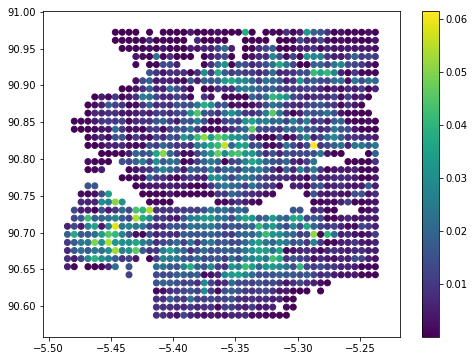

In [18]:
stacked_df['lat'] = stacked_df.geohash6.apply(lambda x: geohash.decode(x)[0])
stacked_df['long'] = stacked_df.geohash6.apply(lambda x: geohash.decode(x)[1])

temp_df = df[df.day == d]
temp_df = temp_df.groupby('geohash6').mean()
figure(num=None, figsize=(8, 6))
plt.scatter(stacked_df.lat.values, stacked_df.long.values, c=stacked_df['rmse(t+1)'].values)
plt.colorbar()
plt.show()

### Totally should have added

In [ ]:
!mkdir ../metrics/target_1
!mkdir ../metrics/target_2
!mkdir ../metrics/target_3
!mkdir ../metrics/target_4
!mkdir ../metrics/target_5

In [ ]:
for t in range(5):
    t2 = t + 1
    print(t, 4)
    for TEST_GEOHASH in eval_df.geohash6.unique():
        gh_df = eval_df[eval_df.geohash6 == TEST_GEOHASH]
        Y_preds = final_stacked.predict([
            gh_df[raw_feat],
            gh_df[last_week_today_feat],
            gh_df[last_six_day_feat],
            gh_df[last_two_hour_feat]
        ])
        figure(num=None, figsize=(25, 6))
        x_axis = np.arange(eval_df[eval_df.geohash6 == TEST_GEOHASH].shape[0])
        plt.plot(x_axis, Y_eval[eval_df.geohash6 == TEST_GEOHASH]['target_{0}'.format(t2)])
        plt.plot(x_axis, Y_preds[:, t])
        plt.savefig('../metrics/target_{0}/{1}.png'.format(t2, TEST_GEOHASH))
        plt.close('all')

## A more 'powerful' model (training 100% of the data)
- this is to evaluate the test/holdout dataset

In [13]:
df = pd.read_pickle('../data/preprocessed_df_for_training.pkl')
X_train_raw = df[raw_feat]
X_train_last_two_hour = df[last_two_hour_feat]
X_train_last_week = df[last_week_today_feat]
X_train_last_six_day = df[last_six_day_feat]
Y_train = df[target]

In [14]:
final_stacked.compile(optimizer=Adagrad(lr=3e-4), loss=mean_squared_error, metrics=[root_mean_squared_error],)
final_stacked.fit(
    [X_train_raw, X_train_last_week, X_train_last_six_day, X_train_last_two_hour], Y_train,
    batch_size=256, epochs=8)

Epoch 1/8
6877575/6877575 [==============================] - 624s 91us/step - loss: 7.4924e-04 - root_mean_squared_error: 0.0270
Epoch 2/8
6877575/6877575 [==============================] - 687s 100us/step - loss: 7.4812e-04 - root_mean_squared_error: 0.0270
Epoch 3/8
6877575/6877575 [==============================] - 651s 95us/step - loss: 7.4770e-04 - root_mean_squared_error: 0.0270
Epoch 4/8
6877575/6877575 [==============================] - 672s 98us/step - loss: 7.4736e-04 - root_mean_squared_error: 0.0270
Epoch 5/8
6877575/6877575 [==============================] - 636s 92us/step - loss: 7.4712e-04 - root_mean_squared_error: 0.0270
Epoch 6/8
6877575/6877575 [==============================] - 739s 107us/step - loss: 7.4691e-04 - root_mean_squared_error: 0.0270
Epoch 7/8
6877575/6877575 [==============================] - 680s 99us/step - loss: 7.4671e-04 - root_mean_squared_error: 0.0270
Epoch 8/8
6877575/6877575 [==============================] - 611s 89us/step - loss: 7.4654e-04 

In [15]:
final_stacked.save('../model/final_stacked_100.h5')

### More epochs! (do not see any significant improvement)

In [20]:
final_stacked.compile(optimizer=Adagrad(lr=1e-4), loss=mean_squared_error, metrics=[root_mean_squared_error],)
final_stacked.fit(
    [X_train_raw, X_train_last_week, X_train_last_six_day, X_train_last_two_hour], Y_train,
    batch_size=256, epochs=32)

Epoch 1/32
6877575/6877575 [==============================] - 610s 89us/step - loss: 7.4872e-04 - root_mean_squared_error: 0.0270
Epoch 2/32
6877575/6877575 [==============================] - 490s 71us/step - loss: 7.4845e-04 - root_mean_squared_error: 0.0270
Epoch 3/32
6877575/6877575 [==============================] - 521s 76us/step - loss: 7.4834e-04 - root_mean_squared_error: 0.0270
Epoch 4/32
6877575/6877575 [==============================] - 598s 87us/step - loss: 7.4826e-04 - root_mean_squared_error: 0.0270
Epoch 5/32
6877575/6877575 [==============================] - 537s 78us/step - loss: 7.4819e-04 - root_mean_squared_error: 0.0270
Epoch 6/32
2784256/6877575 [===========>..................] - ETA: 7:11 - loss: 7.4919e-04 - root_mean_squared_error: 0.0270

KeyboardInterrupt: 